## Description

This notebook implments modifications over the standard notebook of this project.

I have created a validation dataset to be used during the training time in order to prevents overfitting.

A hyperparameter job was also implemented in order to explorer better possible models.

A marginal gain of 0.01 AUC-ROC was reached in comparison with standard code.

### Load Packages

In [2]:
import os
import pandas as pd
import torch
import torch.utils.data
import torch.optim as optim
from train.model import LSTMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [4]:
from enhanced.utils import download_data
from enhanced.preparation import read_imdb_data, prepare_imdb_data, split_train_validation_data
from enhanced.processing import review_to_words, preprocess_data, build_dict
from enhanced.processing import update_save_dict, convert_and_pad_data
from enhanced.training import train
from enhanced.prediction import predict, test_reviews

### Configurations

In [5]:
# Raw data parameters
data_dir = "data"
raw_folder = "aclImdb"
data_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

# Data processing parameters
vocab_size = 5000
sample_idx = 0
cache_dir = os.path.join("cache", "sentiment_analysis")
pytorch_dir = 'data/pytorch'

# Sagemaker Parameters
region = "us-east-1"
bucket_prefix = 'sagemaker/sentiment_rnn'
account_role = "arn:aws:iam::977053370764:role/service-role/AmazonSageMaker-ExecutionRole-20201202T141643"

size_pred = 512

### Step 1: Downloading the data

In [6]:
download_data(data_dir, data_url, filename)

data already downloaded


### Step 2: Processing raw data

In [7]:
data, labels = read_imdb_data(data_dir, raw_folder)

In [8]:
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


### Step 3: Split train-validation-test data

In [9]:
train_valid_X, test_X, train_valid_y, test_y = prepare_imdb_data(data, labels)

In [10]:
train_X, valid_X, train_y, valid_y = split_train_validation_data(train_valid_X, train_valid_y, valid_size=0.001)

In [11]:
print("IMDb reviews (combined): train = {}, valid = {}, test = {}".format(len(train_X), len(valid_X),len(test_X)))

IMDb reviews (combined): train = 24975, valid = 25, test = 25000


In [12]:
print("IMDB reviews: train = {} pos / {} neg, validation = {} pos / {} neg".format(
            sum(train_y), len(train_y)-sum(train_y),
            sum(valid_y), len(valid_y)-sum(valid_y)))

IMDB reviews: train = 12488 pos / 12487 neg, validation = 12 pos / 13 neg


#### Check reviews

In [13]:
print(f"sentiment: {train_y[sample_idx]}")
print(f"review: {train_X[sample_idx]}")

sentiment: 0
review: I went in to see D-War on a whim and with very low expectations. The movie failed to meet them.<br /><br />I don't mind stories that stretch credulity - remember Reign of Fire? - but I do expect them to be internally consistent. This film leapt from howler to howler without pausing for breath, all interspersed with special effects that lagged far behind the likes of LOTR or even Godzilla.<br /><br />A shape-shifting mystic warrior from Korea, curiously metamorphosed into a Caucasian antique dealer and popping up like deus ex machina to get the hapless protagonists out of their latest mess. A special agent from the FBI who seems to be completely boned up on ancient Korean folklore because of the Fed's excellent "paranormal division" - which has gone unremarked up to this point. Lovers kissing on deserted beaches where one exclaims "I never meant for this to happen." A reincarnated pair of long dead Koreans who "died like star-crossed lovers." Mystic pendants, facele

In [14]:
print(f"sentiment: {valid_y[sample_idx]}")
print(f"review: {valid_X[sample_idx]}")

sentiment: 0
review: Shintarô Katsu gained tons of fame playing the wonderful character, Zatoichi. The Zatoichi films had a weird and unbelievable concept--a blind guy is the greatest swordsman in Japan and spends each movie righting wrongs and exacting retribution on evil doers. He's a heck of a nice guy and the films are exciting and addictive (I've actually seen every movie). It is because of this I saw this final installment of the Hanzo the Razor series, as I assumed it would be very similar....and boy was I wrong! It turns out that the Hanzo films are extremely sexual in nature and they also promote the rape of "women who deserve it". You see, Hanzo is a policeman from the Meiji period and he regularly takes evil women into custody and interrogates them by violently raping them with his "penis of steel". How he made his member so strong is something you have to see to believe, but it certainly is NOT for the squeamish.<br /><br />Overall, I just can't recommend anyone sees these 

In [15]:
print(f"sentiment: {test_y[sample_idx]}")
print(f"review: {test_X[sample_idx]}")

sentiment: 0
review: There is nothing good to say about this movie. Read Revolution For the Hell of It or any of his other writings. Abbie was often dismissed as the clown-prince of the '60's, but he was a man of ideas who used his cleverness, his sense of humor and pop culture, and his flamboyant personality to get attention to his ideas. The media too often concentrated on the man, not the ideas, and that's the problem with this movie, too. Later in his life he did suffer from depression. But this flick is like a National Enquirer version of Abbie. He deserves better. If you don't know Abbie or his times, this movie won't help.<br /><br /> This film lies. I give it a zero. <br /><br />


### Step 4: Processing data

In [17]:
train_pp_X, test_pp_X, valid_pp_X, train_pp_y, test_pp_y, valid_pp_y = preprocess_data(train_X, test_X, valid_X,
                                                                           train_y, test_y, valid_y, cache_dir)

100%|██████████| 25000/25000 [08:31<00:00, 48.87it/s]


Wrote preprocessed data to cache file: preprocessed_data.pkl


#### Check tokenization

In [18]:
print(review_to_words(train_X[sample_idx]))

['went', 'see', 'war', 'whim', 'low', 'expect', 'movi', 'fail', 'meet', 'mind', 'stori', 'stretch', 'credul', 'rememb', 'reign', 'fire', 'expect', 'intern', 'consist', 'film', 'leapt', 'howler', 'howler', 'without', 'paus', 'breath', 'interspers', 'special', 'effect', 'lag', 'far', 'behind', 'like', 'lotr', 'even', 'godzilla', 'shape', 'shift', 'mystic', 'warrior', 'korea', 'curious', 'metamorphos', 'caucasian', 'antiqu', 'dealer', 'pop', 'like', 'deu', 'ex', 'machina', 'get', 'hapless', 'protagonist', 'latest', 'mess', 'special', 'agent', 'fbi', 'seem', 'complet', 'bone', 'ancient', 'korean', 'folklor', 'fed', 'excel', 'paranorm', 'divis', 'gone', 'unremark', 'point', 'lover', 'kiss', 'desert', 'beach', 'one', 'exclaim', 'never', 'meant', 'happen', 'reincarn', 'pair', 'long', 'dead', 'korean', 'die', 'like', 'star', 'cross', 'lover', 'mystic', 'pendant', 'faceless', 'hord', 'robot', 'soldier', 'owe', 'lot', 'peter', 'jackson', 'orc', 'serpent', 'wast', 'much', 'time', 'roar', 'everi',

In [19]:
print(review_to_words(valid_X[sample_idx]))

['shintar', 'katsu', 'gain', 'ton', 'fame', 'play', 'wonder', 'charact', 'zatoichi', 'zatoichi', 'film', 'weird', 'unbeliev', 'concept', 'blind', 'guy', 'greatest', 'swordsman', 'japan', 'spend', 'movi', 'right', 'wrong', 'exact', 'retribut', 'evil', 'doer', 'heck', 'nice', 'guy', 'film', 'excit', 'addict', 'actual', 'seen', 'everi', 'movi', 'saw', 'final', 'instal', 'hanzo', 'razor', 'seri', 'assum', 'would', 'similar', 'boy', 'wrong', 'turn', 'hanzo', 'film', 'extrem', 'sexual', 'natur', 'also', 'promot', 'rape', 'women', 'deserv', 'see', 'hanzo', 'policeman', 'meiji', 'period', 'regularli', 'take', 'evil', 'women', 'custodi', 'interrog', 'violent', 'rape', 'peni', 'steel', 'made', 'member', 'strong', 'someth', 'see', 'believ', 'certainli', 'squeamish', 'overal', 'recommend', 'anyon', 'see', 'violent', 'misogynist', 'film', 'howev', 'look', 'review', 'see', 'still', 'popular', 'pretti', 'scari', 'despit', 'decent', 'act', 'amaz', 'fight', 'scene', 'film', 'like', 'brain', 'pollut', '

In [20]:
print(review_to_words(test_X[sample_idx]))

['noth', 'good', 'say', 'movi', 'read', 'revolut', 'hell', 'write', 'abbi', 'often', 'dismiss', 'clown', 'princ', '60', 'man', 'idea', 'use', 'clever', 'sens', 'humor', 'pop', 'cultur', 'flamboy', 'person', 'get', 'attent', 'idea', 'media', 'often', 'concentr', 'man', 'idea', 'problem', 'movi', 'later', 'life', 'suffer', 'depress', 'flick', 'like', 'nation', 'enquir', 'version', 'abbi', 'deserv', 'better', 'know', 'abbi', 'time', 'movi', 'help', 'film', 'lie', 'give', 'zero']


### Step 5: Build dictionary

In [21]:
word_dict, sorted_words, word_count = build_dict(train_pp_X, vocab_size=vocab_size)

#### Check word dictionary

In [22]:
pd.DataFrame(word_count.items(), columns = ["word", "count"]).sort_values(by="count",ascending=False).head()

,word,count
30633,movi,51667
16391,film,48155
32773,one,27720
26623,like,22784
45985,time,16169


#### Update word dictionary

In [82]:
words_to_remove = [] #["film"] # [] # ["movi", "film"]

In [83]:
updated_dict, new_vocab_size = update_save_dict(word_dict, pytorch_dir, words_to_remove)

#### Convert and pad data

In [84]:
train_tf_X, train_X_tf_len = convert_and_pad_data(updated_dict, train_pp_X)

100%|██████████| 24975/24975 [00:00<00:00, 31836.75it/s]


In [85]:
test_tf_X, test_X_tf_len = convert_and_pad_data(updated_dict, test_pp_X)

100%|██████████| 25000/25000 [00:01<00:00, 23165.05it/s]


In [86]:
valid_tf_X, valid_X_tf_len = convert_and_pad_data(updated_dict, valid_pp_X)

100%|██████████| 25/25 [00:00<00:00, 29119.02it/s]


### Step 6: Local Training

In [87]:
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_tf_len), pd.DataFrame(train_tf_X)], axis=1) \
        .to_csv(os.path.join(pytorch_dir, 'train.csv'), header=False, index=False)

pd.concat([pd.DataFrame(valid_y), pd.DataFrame(valid_X_tf_len), pd.DataFrame(valid_tf_X)], axis=1) \
        .to_csv(os.path.join(pytorch_dir, 'valid.csv'), header=False, index=False)

In [88]:
# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(pytorch_dir, 'train.csv'), header=None, names=None, nrows=250)
valid_sample = pd.read_csv(os.path.join(pytorch_dir, 'valid.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

valid_sample_y = torch.from_numpy(valid_sample[[0]].values).float().squeeze()
valid_sample_X = torch.from_numpy(valid_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
valid_sample_ds = torch.utils.data.TensorDataset(valid_sample_X, valid_sample_y)

# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)
valid_sample_dl = torch.utils.data.DataLoader(valid_sample_ds, batch_size=50)

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


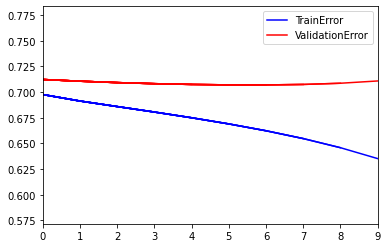

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 30, new_vocab_size).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

report_train, trained_model = train(model, train_sample_dl, valid_sample_dl, 10, optimizer, loss_fn, device)

### Step 7: Sagemaker Training

#### Initial setup

In [104]:
sagemaker_session = sagemaker.Session(boto_session=boto3.session.Session(region_name=region))

bucket = sagemaker_session.default_bucket()

role = account_role

#### Upload data

In [105]:
input_data = sagemaker_session.upload_data(path=pytorch_dir, bucket=bucket, key_prefix=bucket_prefix)

#### Create estimator

In [106]:
estimator = PyTorch(entry_point="train.py",
                    source_dir="enhanced",
                    py_version="py3",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={"vocab_size": new_vocab_size
                                     })

In [107]:
estimator_tuner = HyperparameterTuner(estimator = estimator,
                                      objective_metric_name = 'validation:loss',
                                      metric_definitions = [{"Name": "validation:loss","Regex": "BCELoss: (.*?);"}],
                                      objective_type = 'Minimize',
                                      max_jobs = 10, # The total number of models to train
                                      max_parallel_jobs = 1, # The number of models to train in parallel
                                      hyperparameter_ranges = {
                                          'epochs': IntegerParameter(10,20),
                                          "hidden_dim": IntegerParameter(30,500)
                                          
                                      }
                                     )

#### Tunning job

In [108]:
estimator_tuner.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [109]:
estimator_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

#### Create deploy

In [110]:
best_model = estimator_tuner.best_training_job()

In [111]:
best_estimator = sagemaker.estimator.Estimator.attach(best_model)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-12-15 04:24:00 Starting - Preparing the instances for training
2020-12-15 04:24:00 Downloading - Downloading input data
2020-12-15 04:24:00 Training - Training image download completed. Training in progress.
2020-12-15 04:24:00 Uploading - Uploading generated training model
2020-12-15 04:24:00 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-15 04:18:50,395 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-12-15 04:18:50,396 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value validation:loss to Json.
Returning the value itself
2020-12-15 04:18:50,426 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-15 04:18:51,050 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-12-15 04:18:51,314 sagemaker-containers INFO     Module tr

Epoch: 4; BCELoss: 0.42596566677093506;
Epoch: 5; BCELoss: 0.3929729163646698;
Epoch: 6; BCELoss: 0.3318275809288025;
Epoch: 7; BCELoss: 0.3233320116996765;
Epoch: 8; BCELoss: 0.28102168440818787;
Epoch: 9; BCELoss: 0.2678567171096802;
Epoch: 10; BCELoss: 0.2566576600074768;
Epoch: 11; BCELoss: 0.19566310942173004;
Epoch: 12; BCELoss: 0.22133222222328186;
Epoch: 13; BCELoss: 0.19654566049575806;
Epoch: 14; BCELoss: 0.23711618781089783;
Epoch: 15; BCELoss: 0.18776950240135193;
Epoch: 16; BCELoss: 0.19244743883609772;
Epoch: 17; BCELoss: 0.19706635177135468;
Epoch: 18; BCELoss: 0.20140592753887177;
Epoch: 19; BCELoss: 0.16515566408634186;
Epoch: 20; BCELoss: 0.17554472386837006;
2020-12-15 04:22:52,747 sagemaker-containers INFO     Reporting training SUCCESS
Training seconds: 375
Billable seconds: 375


### Step 8: Sagemaker Deploy

In [112]:
class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=best_estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version="py3",
                     source_dir='serve',
                     predictor_cls=StringPredictor)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [113]:
endpoint = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

In [114]:
endpoint.endpoint

'sagemaker-pytorch-2020-12-15-04-45-30-001'

#### Predict data

In [115]:
import glob
import os
from tqdm import tqdm
import boto3

def test_reviews(endpoint_name, data_dir='data/aclImdb', stop=5000):
    
    client = boto3.client("sagemaker-runtime")
    results = []
    ground = []
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        files_read = 0
        print('Starting ', sentiment, ' files')
        # Iterate through the files and send them to the predictor
        for f in tqdm(files):
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                try:
                    # Read in the review and convert to 'utf-8' for transmission via HTTP
                    review_input = review.read().encode('utf-8')
                    # Send the review to the predictor and store the results
                    response = client.invoke_endpoint(EndpointName=endpoint.endpoint, Body=review_input,ContentType='text/plain')
                    results.append(float(response["Body"].read().decode('utf-8')))
                    if sentiment == 'pos':
                        ground.append(1)
                    else:
                        ground.append(0)
                except:
                    pass
                #print(results)
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [116]:
ground, results = test_reviews(endpoint.endpoint, stop=250)

  0%|          | 0/12500 [00:00<?, ?it/s]

Starting  pos  files


  0%|          | 0/12500 [00:00<?, ?it/s]

Starting  neg  files


  2%|▏         | 249/12500 [01:17<1:03:22,  3.22it/s]


#### Evaluate results

In [117]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(ground, results)
fpr, tpr, _ = roc_curve(ground, results)

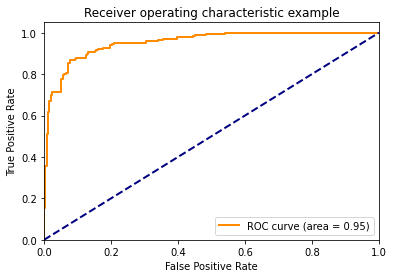

In [118]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Finish

In [119]:
endpoint.delete_endpoint()

### Website

<p align="center">
<img src="https://i.imgur.com/SCd77Hs.gif">
    </p>